<a href="https://colab.research.google.com/github/tztechno/cc_archive/blob/main/AvatarArtist1_2D_Domain_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# success 12/24 14:32
# output styled was moved to google drive manually


## **Step1**
# **AvatarArtist1: 2D Domain Transfer**

https://kumapowerliu.github.io/AvatarArtist/

Step1: https://www.kaggle.com/code/stpeteishii/avatarartist1-2d-domain-transfer

Step2: https://www.kaggle.com/code/stpeteishii/avatarartist2-next3d-4d-gan-fine-tuning

Step3: https://www.kaggle.com/code/stpeteishii/avatarartist3-triplane-decomposition

Step4: https://www.kaggle.com/code/stpeteishii/avatarartist4-diffusion-transformer-training

Step5: https://www.kaggle.com/code/stpeteishii/avatarartist5-avatar-generation-inference

In [ ]:
from google.colab import userdata
hf_token0=userdata.get('secret_hf_token')

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install diffusers transformers accelerate
!pip install controlnet-aux opencv-python pillow
!pip install mediapipe==0.10.9

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 17.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement mediapipe==0.10.9 (from versions: 0.10.13, 0.10.14, 0.10.15, 0.10.18, 0.10.20, 0.10.21, 0.10.30, 0.10.31)
ERROR: No matching distribution found for mediapipe==0.10.9


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

from google.colab import drive
drive.mount('/content/drive')

import os
gd_path='/content/drive/MyDrive/your_folder/pins_dataset'
#os.makedirs('/content/pins_dataset', exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os
import random

paths=[]
for dirname, _, filenames in os.walk(gd_path):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
print(paths[0:6])
random.shuffle(paths)

['/content/drive/MyDrive/your_folder/pins_dataset/avatarartist1-2d-domain-transfer.ipynb', '/content/drive/MyDrive/your_folder/pins_dataset/pins_Brenton Thwaites/Brenton Thwaites219_843.jpg', '/content/drive/MyDrive/your_folder/pins_dataset/pins_Brenton Thwaites/Brenton Thwaites232_854.jpg', '/content/drive/MyDrive/your_folder/pins_dataset/pins_Brenton Thwaites/Brenton Thwaites90_928.jpg', '/content/drive/MyDrive/your_folder/pins_dataset/pins_Brenton Thwaites/Brenton Thwaites181_803.jpg', '/content/drive/MyDrive/your_folder/pins_dataset/pins_Brenton Thwaites/Brenton Thwaites165_793.jpg']


In [ ]:
os.makedirs("input_images", exist_ok=True)
for path in paths[0:100]:
    shutil.copy(path, "/content/input_images")

for dirname, _, filenames in os.walk('/content/input_images'):
    for filename in filenames:
        print(filename)

Brenton Thwaites57_895.jpg
melissa fumero154_3316.jpg
Brenton Thwaites146_774.jpg
melissa fumero219_3365.jpg
Selena Gomez174_4376.jpg
Stephen Amell33_4198.jpg
Anne Hathaway57_459.jpg
Anne Hathaway222_404.jpg
Natalie Portman42_3557.jpg
Brenton Thwaites90_928.jpg
camila mendes95_1108.jpg
Nadia Hilker241_83 (1).jpg
Tuppence Middleton108_2553.jpg
Maisie Williams202_2587.jpg
Maisie Williams209_2592.jpg
Selena Gomez23_4426.jpg
Anne Hathaway113_307.jpg
Anne Hathaway147_338.jpg
Lindsey Morgan45_2243.jpg
margot robbie85_3264.jpg
ellen page160_1386.jpg
Amanda Crew44_82.jpg
margot robbie93_3273.jpg
melissa fumero233_3374.jpg
Inbar Lavi77_1568.jpg
Brenton Thwaites73_912.jpg
Neil Patrick Harris164_3647.jpg
ellen page203_1420.jpg
Neil Patrick Harris88_3715.jpg
Neil Patrick Harris223_3680.jpg
ellen page16_1385.jpg
Lindsey Morgan26_2228.jpg
Stephen Amell41_4206.jpg
Selena Gomez11_4326.jpg
Brenton Thwaites85_923.jpg
Lindsey Morgan158_2162.jpg
margot robbie48_3230.jpg
Maisie Williams84_2675.jpg
Anne Hat

In [ ]:
"""
AvatarArtist: 2D Domain Transfer Script
Converts real-life images into specific styles using
Stable Diffusion + ControlNet + SDEdit.

[IMPORTANT] Hugging Face Token Setup:
Method 1: Environment Variable
  export HF_TOKEN="your_token_here"

Method 2: Command Line
  huggingface-cli login

Method 3: Specify in Code
  artist = AvatarArtist2D(hf_token="your_token_here")
"""

import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from typing import Optional, List, Tuple
import cv2
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    DDIMScheduler,
    UniPCMultistepScheduler
)
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector, CannyDetector

# MediaPipe is optional
try:
    import mediapipe as mp
    MEDIAPIPE_AVAILABLE = True
except ImportError:
    MEDIAPIPE_AVAILABLE = False
    print("Warning: MediaPipe not available. Using ControlNet only for pose detection.")


class AvatarArtist2D:
    """Main class for 2D domain transfer."""

    def __init__(
        self,
        model_id: str = "runwayml/stable-diffusion-v1-5",
        controlnet_model: str = "lllyasviel/sd-controlnet-openpose",
        device: str = "cuda",
        dtype: torch.dtype = torch.float16,
        use_canny: bool = False,
        hf_token: Optional[str] = hf_token0
    ):
        """
        Args:
            model_id: Path or ID for the Stable Diffusion model.
                - "runwayml/stable-diffusion-v1-5" (Recommended: No token required)
                - "stabilityai/stable-diffusion-2-1" (May require a token)
                - "stabilityai/stable-diffusion-xl-base-1.0" (SDXL)
            controlnet_model: Path or ID for the ControlNet model.
            device: Computing device to use.
            dtype: Data type.
            use_canny: Use Canny edge detection (simpler and lightweight).
            hf_token: Hugging Face token (optional).
        """
        self.device = device
        self.dtype = dtype
        self.use_canny = use_canny
        self.hf_token = hf_token or os.environ.get("HF_TOKEN")

        print(f"Using Model: {model_id}")
        print("Loading models...")

        # Select ControlNet based on the base model
        if "stable-diffusion-v1-5" in model_id or "v1-5" in model_id:
            if use_canny:
                controlnet_model = "lllyasviel/sd-controlnet-canny"
            else:
                controlnet_model = "lllyasviel/sd-controlnet-openpose"
        elif "stable-diffusion-2" in model_id:
            if use_canny:
                controlnet_model = "thibaud/controlnet-sd21-canny-diffusers"
            else:
                controlnet_model = "thibaud/controlnet-sd21-openpose-diffusers"

        print(f"ControlNet: {controlnet_model}")

        # Load ControlNet
        try:
            self.controlnet = ControlNetModel.from_pretrained(
                controlnet_model,
                torch_dtype=dtype,
                token=self.hf_token
            )
            print(f"✓ ControlNet loaded successfully")
        except Exception as e:
            print(f"⚠ Error: Failed to load {controlnet_model}")
            print(f"  Details: {e}")
            print("Attempting fallback to Canny model...")
            try:
                fallback_model = "lllyasviel/sd-controlnet-canny"
                self.controlnet = ControlNetModel.from_pretrained(
                    fallback_model,
                    torch_dtype=dtype,
                    token=self.hf_token
                )
                self.use_canny = True
                print(f"✓ Using Canny ControlNet as fallback.")
            except Exception as e2:
                raise Exception(f"Failed to load any ControlNet model: {e2}")

        # Stable Diffusion pipeline setup
        try:
            self.pipe = StableDiffusionControlNetPipeline.from_pretrained(
                model_id,
                controlnet=self.controlnet,
                torch_dtype=dtype,
                safety_checker=None,
                token=self.hf_token
            )
            print(f"✓ Stable Diffusion loaded successfully")
        except Exception as e:
            error_msg = str(e)
            if "gated" in error_msg.lower() or "token" in error_msg.lower():
                raise Exception(
                    f"\n{'='*60}\n"
                    f"🔐 Authentication Error: This model requires a Hugging Face token.\n"
                    f"\nInstructions:"
                    f"\n1. Get a token at: https://huggingface.co/settings/tokens"
                    f"\n2. Set it using one of these methods:"
                    f"\n   a) export HF_TOKEN='your_token'"
                    f"\n   b) huggingface-cli login"
                    f"\n   c) artist = AvatarArtist2D(hf_token='your_token')"
                    f"\n\nAlternatively, use a model that doesn't require a token:"
                    f"\n   model_id='runwayml/stable-diffusion-v1-5'"
                    f"\n{'='*60}\n"
                )
            raise

        # Scheduler configuration (SDEdit compatible)
        self.pipe.scheduler = DDIMScheduler.from_config(
            self.pipe.scheduler.config
        )

        self.pipe = self.pipe.to(device)
        self.pipe.enable_attention_slicing()

        # Control image processor
        if self.use_canny:
            print("Initializing Canny detector...")
            self.processor = CannyDetector()
        else:
            print("Loading Openpose processor...")
            try:
                self.processor = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
            except Exception as e:
                print(f"Warning: OpenPose load failed: {e}")
                print("Falling back to Canny...")
                self.processor = CannyDetector()
                self.use_canny = True

        # MediaPipe Face Detection (Optional: for more detailed control)
        self.face_mesh = None
        if MEDIAPIPE_AVAILABLE:
            try:
                mp_face_mesh = mp.solutions.face_mesh
                self.face_mesh = mp_face_mesh.FaceMesh(
                    static_image_mode=True,
                    max_num_faces=1,
                    min_detection_confidence=0.5
                )
                print("MediaPipe face detection enabled.")
            except Exception as e:
                print(f"MediaPipe initialization failed: {e}")
                self.face_mesh = None

        print("Initialization complete!")

    def extract_pose_landmarks(self, image: Image.Image) -> Image.Image:
        """Extract control image from input (OpenPose or Canny)."""
        control_image = self.processor(image)
        return control_image

    def extract_face_landmarks(self, image: Image.Image) -> Optional[np.ndarray]:
        """Extract face landmarks using MediaPipe."""
        if self.face_mesh is None:
            return None

        try:
            image_np = np.array(image)
            results = self.face_mesh.process(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0]
                h, w = image_np.shape[:2]
                points = np.array([
                    [lm.x * w, lm.y * h]
                    for lm in landmarks.landmark
                ])
                return points
        except Exception as e:
            print(f"Warning: Face landmark extraction failed: {e}")
        return None

    def apply_sdedit(
        self,
        image: Image.Image,
        prompt: str,
        control_image: Image.Image,
        noise_strength: float = 0.5,
        controlnet_conditioning_scale: float = 1.0,
        guidance_scale: float = 7.5,
        num_inference_steps: int = 50,
        seed: Optional[int] = None
    ) -> Image.Image:
        """Perform domain transfer applying SDEdit logic."""
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)
        else:
            generator = None

        output = self.pipe(
            prompt=prompt,
            image=control_image,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            generator=generator,
        )
        return output.images[0]

    def process_single_image(
        self,
        image_path: str,
        output_path: str,
        style_prompt: str,
        noise_strength: float = 0.5,
        controlnet_strength: float = 1.0,
        guidance_scale: float = 7.5,
        num_steps: int = 50,
        seed: Optional[int] = None
    ) -> bool:
        """Process a single image."""
        try:
            image = load_image(image_path)
            image = image.resize((512, 512))

            print(f"  Extracting control image...")
            control_image = self.extract_pose_landmarks(image)

            print(f"  Transforming style...")
            output_image = self.apply_sdedit(
                image=image,
                prompt=style_prompt,
                control_image=control_image,
                noise_strength=noise_strength,
                controlnet_conditioning_scale=controlnet_strength,
                guidance_scale=guidance_scale,
                num_inference_steps=num_steps,
                seed=seed
            )

            output_image.save(output_path)
            print(f"  Saved to: {output_path}")
            return True
        except Exception as e:
            print(f"  Error: {str(e)}")
            return False

    def process_batch(
        self,
        input_dir: str,
        output_dir: str,
        style_prompt: str,
        noise_strength: float = 0.5,
        controlnet_strength: float = 1.0,
        guidance_scale: float = 7.5,
        num_steps: int = 50,
        extensions: List[str] = [".jpg", ".jpeg", ".png"],
        seed: Optional[int] = None
    ):
        """Process all images in a folder."""
        os.makedirs(output_dir, exist_ok=True)
        input_path = Path(input_dir)
        image_files = []
        for ext in extensions:
            image_files.extend(list(input_path.glob(f"*{ext}")))
            image_files.extend(list(input_path.glob(f"*{ext.upper()}")))

        print(f"\nProcessing {len(image_files)} images")
        print(f"Style: {style_prompt}")
        print(f"Noise Strength: {noise_strength}")
        print(f"ControlNet Strength: {controlnet_strength}\n")

        success_count = 0
        for i, img_path in enumerate(image_files, 1):
            print(f"[{i}/{len(image_files)}] Processing: {img_path.name}")
            output_path = os.path.join(output_dir, f"styled_{img_path.name}")

            if self.process_single_image(
                str(img_path), output_path, style_prompt,
                noise_strength, controlnet_strength,
                guidance_scale, num_steps, seed
            ):
                success_count += 1

        print(f"\nFinished: Transformed {success_count}/{len(image_files)} images.")


def main():
    """Main execution entry point."""
    INPUT_DIR = "./input_images"
    OUTPUT_DIR = "./output_styled"

    # Model Selection
    # Option 1: SD 1.5 (Recommended - Fast, no token required)
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    # Option 2: SD 2.1 (Higher quality, may require token)
    # MODEL_ID = "stabilityai/stable-diffusion-2-1"

    # Hugging Face Token (if required)
    # Method 1: Environment variable export HF_TOKEN="your_token"
    # Method 2: Specify directly here
    HF_TOKEN = None  # e.g., "hf_xxxxxxxxxxxxx"

    STYLE_PROMPTS = {
        "pixar": "a 3D render of a face in Pixar animation style, high quality, detailed, professional lighting",
        "anime": "anime style portrait, cel shaded, vibrant colors, expressive eyes, detailed",
        "lego": "LEGO minifigure face, plastic texture, simplified features, toy style",
        "oil_painting": "oil painting portrait, classical style, rich colors, brushstrokes visible",
        "cartoon": "cartoon style portrait, bold lines, vibrant colors, simplified features"
    }

    STYLE = "pixar"
    NOISE_STRENGTH = 0.4 #reduced
    CONTROLNET_STRENGTH = 0.8
    GUIDANCE_SCALE = 7.5
    NUM_STEPS = 50
    SEED = 42
    USE_CANNY = False # True: Canny (Lightweight), False: OpenPose (High Accuracy)

    try:
        artist = AvatarArtist2D(
            model_id=MODEL_ID,
            device="cuda" if torch.cuda.is_available() else "cpu",
            use_canny=USE_CANNY,
            hf_token=HF_TOKEN
        )
    except Exception as e:
        print(f"\n❌ Initialization Error: {e}")
        print("\n💡 Troubleshooting:")
        print("  1. Login to Hugging Face: huggingface-cli login")
        print("  2. Or set environment variable: export HF_TOKEN='your_token'")
        print("  3. Or use a token-free model: MODEL_ID='runwayml/stable-diffusion-v1-5'")
        return

    artist.process_batch(
        input_dir=INPUT_DIR,
        output_dir=OUTPUT_DIR,
        style_prompt=STYLE_PROMPTS[STYLE],
        noise_strength=NOISE_STRENGTH,
        controlnet_strength=CONTROLNET_STRENGTH,
        guidance_scale=GUIDANCE_SCALE,
        num_steps=NUM_STEPS,
        seed=SEED
    )

if __name__ == "__main__":
    main()

Using Model: runwayml/stable-diffusion-v1-5
Loading models...
ControlNet: lllyasviel/sd-controlnet-openpose


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

✓ ControlNet loaded successfully


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ Stable Diffusion loaded successfully
Loading Openpose processor...


annotator/ckpts/body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

annotator/ckpts/hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

Initialization complete!

Processing 100 images
Style: a 3D render of a face in Pixar animation style, high quality, detailed, professional lighting
Noise Strength: 0.4
ControlNet Strength: 0.8

[1/100] Processing: Brenton Thwaites57_895.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites57_895.jpg
[2/100] Processing: melissa fumero154_3316.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero154_3316.jpg
[3/100] Processing: Brenton Thwaites146_774.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites146_774.jpg
[4/100] Processing: melissa fumero219_3365.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero219_3365.jpg
[5/100] Processing: Selena Gomez174_4376.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez174_4376.jpg
[6/100] Processing: Stephen Amell33_4198.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Stephen Amell33_4198.jpg
[7/100] Processing: Anne Hathaway57_459.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway57_459.jpg
[8/100] Processing: Anne Hathaway222_404.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway222_404.jpg
[9/100] Processing: Natalie Portman42_3557.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman42_3557.jpg
[10/100] Processing: Brenton Thwaites90_928.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites90_928.jpg
[11/100] Processing: camila mendes95_1108.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_camila mendes95_1108.jpg
[12/100] Processing: Nadia Hilker241_83 (1).jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Nadia Hilker241_83 (1).jpg
[13/100] Processing: Tuppence Middleton108_2553.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Tuppence Middleton108_2553.jpg
[14/100] Processing: Maisie Williams202_2587.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams202_2587.jpg
[15/100] Processing: Maisie Williams209_2592.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams209_2592.jpg
[16/100] Processing: Selena Gomez23_4426.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez23_4426.jpg
[17/100] Processing: Anne Hathaway113_307.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway113_307.jpg
[18/100] Processing: Anne Hathaway147_338.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway147_338.jpg
[19/100] Processing: Lindsey Morgan45_2243.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan45_2243.jpg
[20/100] Processing: margot robbie85_3264.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie85_3264.jpg
[21/100] Processing: ellen page160_1386.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page160_1386.jpg
[22/100] Processing: Amanda Crew44_82.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Amanda Crew44_82.jpg
[23/100] Processing: margot robbie93_3273.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie93_3273.jpg
[24/100] Processing: melissa fumero233_3374.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero233_3374.jpg
[25/100] Processing: Inbar Lavi77_1568.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Inbar Lavi77_1568.jpg
[26/100] Processing: Brenton Thwaites73_912.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites73_912.jpg
[27/100] Processing: Neil Patrick Harris164_3647.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Neil Patrick Harris164_3647.jpg
[28/100] Processing: ellen page203_1420.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page203_1420.jpg
[29/100] Processing: Neil Patrick Harris88_3715.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Neil Patrick Harris88_3715.jpg
[30/100] Processing: Neil Patrick Harris223_3680.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Neil Patrick Harris223_3680.jpg
[31/100] Processing: ellen page16_1385.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page16_1385.jpg
[32/100] Processing: Lindsey Morgan26_2228.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan26_2228.jpg
[33/100] Processing: Stephen Amell41_4206.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Stephen Amell41_4206.jpg
[34/100] Processing: Selena Gomez11_4326.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez11_4326.jpg
[35/100] Processing: Brenton Thwaites85_923.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites85_923.jpg
[36/100] Processing: Lindsey Morgan158_2162.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan158_2162.jpg
[37/100] Processing: margot robbie48_3230.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie48_3230.jpg
[38/100] Processing: Maisie Williams84_2675.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams84_2675.jpg
[39/100] Processing: Anne Hathaway202_390.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway202_390.jpg
[40/100] Processing: Anne Hathaway180_367.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway180_367.jpg
[41/100] Processing: camila mendes187_1010.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_camila mendes187_1010.jpg
[42/100] Processing: Natalie Portman91_3597.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman91_3597.jpg
[43/100] Processing: Maisie Williams176_2563.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams176_2563.jpg
[44/100] Processing: Anne Hathaway78_477.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway78_477.jpg
[45/100] Processing: Natalie Portman141_3462.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman141_3462.jpg
[46/100] Processing: Anne Hathaway166_353.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway166_353.jpg
[47/100] Processing: ellen page14_1367.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page14_1367.jpg
[48/100] Processing: Natalie Portman232_3532.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman232_3532.jpg
[49/100] Processing: Inbar Lavi69_1560.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Inbar Lavi69_1560.jpg
[50/100] Processing: Tuppence Middleton248_2622.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Tuppence Middleton248_2622.jpg
[51/100] Processing: ellen page52_1484.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page52_1484.jpg
[52/100] Processing: Maisie Williams2_2584.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams2_2584.jpg
[53/100] Processing: Anne Hathaway153_344.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway153_344.jpg
[54/100] Processing: Neil Patrick Harris1_3603.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Neil Patrick Harris1_3603.jpg
[55/100] Processing: Dwayne Johnson160_1602.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson160_1602.jpg
[56/100] Processing: Lindsey Morgan154_2159.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan154_2159.jpg
[57/100] Processing: Brenton Thwaites52_892.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites52_892.jpg
[58/100] Processing: Amanda Crew78_102.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Amanda Crew78_102.jpg
[59/100] Processing: Nadia Hilker226_75.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Nadia Hilker226_75.jpg
[60/100] Processing: Brenton Thwaites102_732.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites102_732.jpg
[61/100] Processing: Lindsey Morgan105_2119.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan105_2119.jpg
[62/100] Processing: melissa fumero179_3335.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero179_3335.jpg
[63/100] Processing: Natalie Portman206_3513.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman206_3513.jpg
[64/100] Processing: margot robbie92_3272.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie92_3272.jpg
[65/100] Processing: ellen page21_1424.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page21_1424.jpg
[66/100] Processing: Selena Gomez237_4431.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez237_4431.jpg
[67/100] Processing: Brenton Thwaites219_841.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites219_841.jpg
[68/100] Processing: Selena Gomez93_4496.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez93_4496.jpg
[69/100] Processing: Inbar Lavi190_1496.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Inbar Lavi190_1496.jpg
[70/100] Processing: Brenton Thwaites151_778.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites151_778.jpg
[71/100] Processing: Lindsey Morgan205_2202.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan205_2202.jpg
[72/100] Processing: Dwayne Johnson99_1699.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson99_1699.jpg
[73/100] Processing: Amanda Crew124_20.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Amanda Crew124_20.jpg
[74/100] Processing: melissa fumero176_3332.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero176_3332.jpg
[75/100] Processing: Nadia Hilker134_26.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Nadia Hilker134_26.jpg
[76/100] Processing: ellen page82_1510.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page82_1510.jpg
[77/100] Processing: margot robbie113_3071.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie113_3071.jpg
[78/100] Processing: melissa fumero52_3403.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_melissa fumero52_3403.jpg
[79/100] Processing: Neil Patrick Harris32_3693.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Neil Patrick Harris32_3693.jpg
[80/100] Processing: Tuppence Middleton159_2587.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Tuppence Middleton159_2587.jpg
[81/100] Processing: Brenton Thwaites9_927.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites9_927.jpg
[82/100] Processing: margot robbie147_3110.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie147_3110.jpg
[83/100] Processing: Anne Hathaway225_407.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Anne Hathaway225_407.jpg
[84/100] Processing: Tuppence Middleton143_2573.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Tuppence Middleton143_2573.jpg
[85/100] Processing: Brenton Thwaites124_752.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites124_752.jpg
[86/100] Processing: ellen page208_1423.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_ellen page208_1423.jpg
[87/100] Processing: Brenton Thwaites48_887.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites48_887.jpg
[88/100] Processing: Dwayne Johnson137_1588.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson137_1588.jpg
[89/100] Processing: Brenton Thwaites91_929.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Brenton Thwaites91_929.jpg
[90/100] Processing: Dwayne Johnson33_1662.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson33_1662.jpg
[91/100] Processing: Natalie Portman54_3568.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Natalie Portman54_3568.jpg
[92/100] Processing: Dwayne Johnson183_1614.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson183_1614.jpg
[93/100] Processing: Maisie Williams15_2539.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Maisie Williams15_2539.jpg
[94/100] Processing: Lindsey Morgan21_2204.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan21_2204.jpg
[95/100] Processing: margot robbie181_3146.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_margot robbie181_3146.jpg
[96/100] Processing: Stephen Amell112_4098.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Stephen Amell112_4098.jpg
[97/100] Processing: Selena Gomez71_4477.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Selena Gomez71_4477.jpg
[98/100] Processing: Dwayne Johnson187_1615.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Dwayne Johnson187_1615.jpg
[99/100] Processing: Lindsey Morgan86_2268.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Lindsey Morgan86_2268.jpg
[100/100] Processing: Amanda Crew111_12.jpg
  Extracting control image...
  Transforming style...


  0%|          | 0/50 [00:00<?, ?it/s]

  Saved to: ./output_styled/styled_Amanda Crew111_12.jpg

Finished: Transformed 100/100 images.


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_image(image_dir):
    image_paths = [
        os.path.join(image_dir, f)
        for f in sorted(os.listdir(image_dir))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ][:6]
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path), fontsize=9)
    for ax in axes[len(image_paths):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

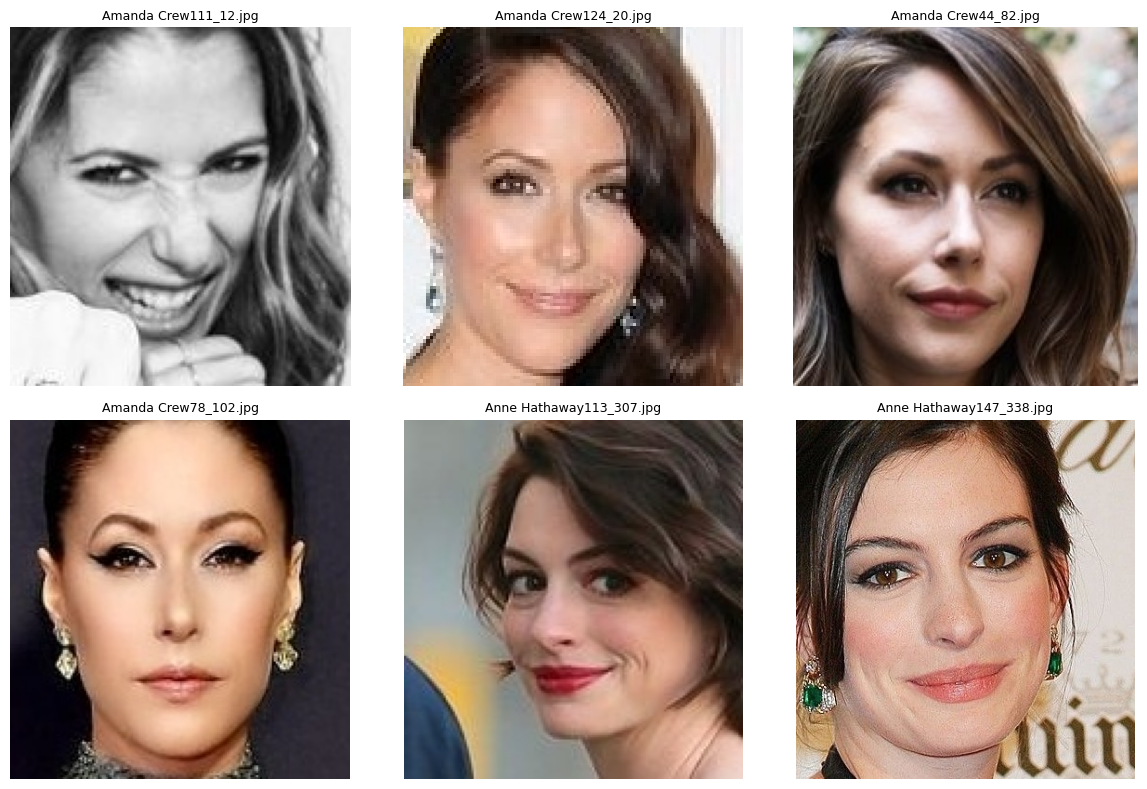

In [ ]:
show_image('input_images')

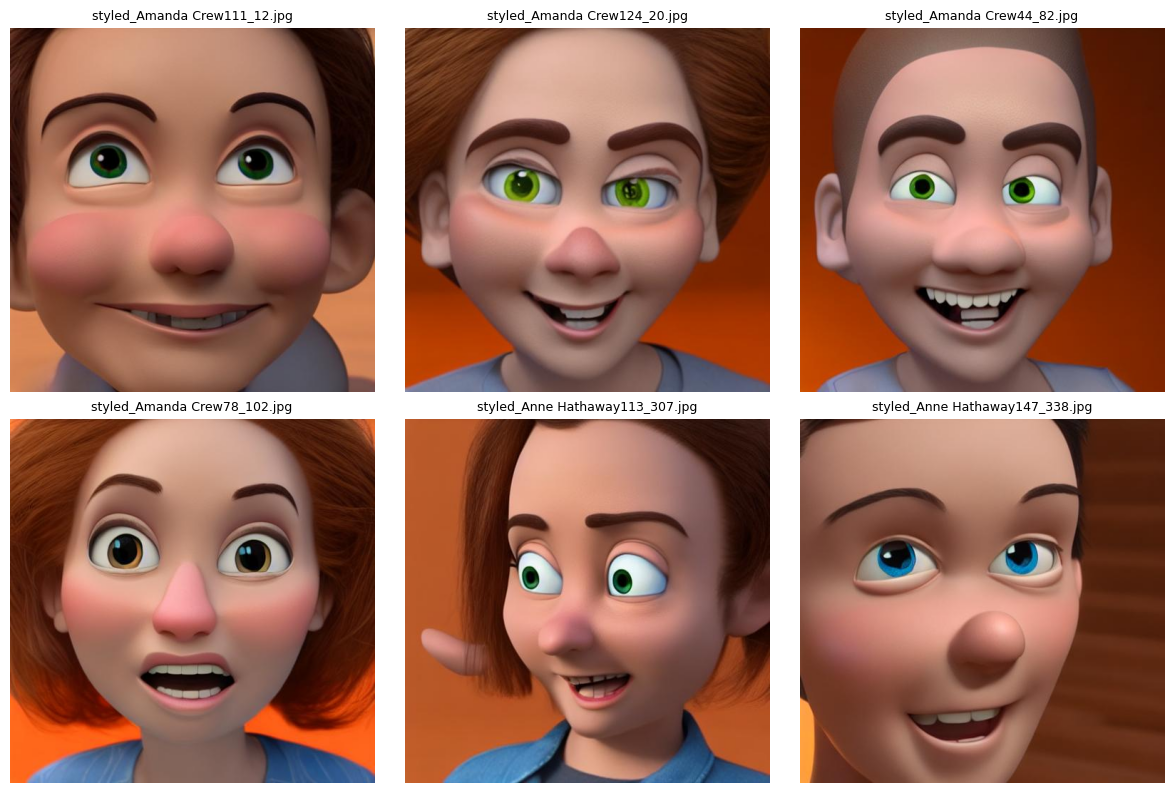

In [ ]:
show_image('output_styled')